# Illustrative CDR needs

In this notebook, we pull out the CDR needs for 5 illustrative mitigation pathways from Gidden et al., (2024).

In [1]:
import pooch

import pandas as pd
import pyam
import matplotlib.pyplot as plt

import os
from pathlib import Path

Step 1: Retrieve the required input files from Gidden et al.

In [2]:
if os.path.exists('input_data') is False:
    os.mkdir('input_data')

In [3]:
file_path = pooch.retrieve(
    url='https://zenodo.org/records/10158920/files/10.5281_zenodo.10158920_gidden_et_al_2023_ar6_reanalysis_data.xlsx',
    path='input_data',
    known_hash='md5:cf117bd4905889f46839211265adac9d'
)

In [4]:
df = pyam.IamDataFrame(file_path)

[INFO] 13:21:39 - pyam.core: Reading file \\srv-mcc-fs\home\gang\codebases\CDR_Portfolios\assessment\input_data\96e1ae981d9979c614e9a7a3151915ac-10.5281_zenodo.10158920_gidden_et_al_2023_ar6_reanalysis_data.xlsx
[INFO] 13:22:54 - pyam.core: Found column 'exclude' in sheet 'meta', moved to attribute `IamDataFrame.exclude`.


Step 2: Check if there is an IMP marker metadata column

In [5]:
df.meta['IMP_marker'].unique()

array([nan, 'Neg-2.0', 'Neg', 'CurPol', 'ModAct', 'LD', 'Ren-2.0', 'SP',
       'Ren', 'GS'], dtype=object)

Step 3: Identify characteristics of the marker scenarios.

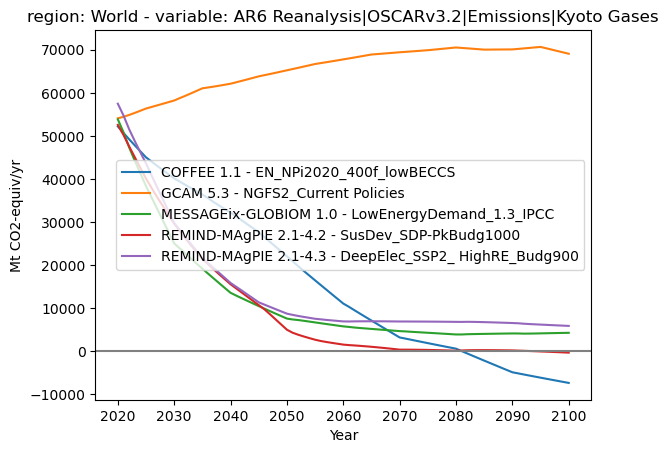

In [6]:
fig, ax = plt.subplots()
df.filter(
    IMP_marker=[
        'Ren',
        'LD',
        'SP',
        'Neg',
        'CurPol'
    ],
    variable='AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
    region='World',
    year=range(2020,2101)
).plot(ax=ax)
ax.axhline(0, color='grey')

In [7]:
marker_scens_world = (
    df
    .filter(
        IMP_marker=[
            'Ren',
            'LD',
            'SP',
            'Neg',
            'CurPol'
        ],
        region='World'
    )
)

Step 4: Pull out and calculate cumulative CDR deployed.

In [8]:
cdr = (
    marker_scens_world
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal',
        year=range(2020,2101)
    )
    .convert_unit(
        current='Mt CO2/yr',
        to='Gt CO2/yr'
    )
    .timeseries()
    .apply(
        lambda x: pyam.timeseries.cumulative(
            x,
            first_year=2020,
            last_year=2100
        ),
        axis=1
    )
    .round(0)
)

Step 5: Cast to a pandas dataframe and add a column with explanatory comments.

In [9]:
compiled_cdr_data = (
    pd
    .DataFrame(cdr)
    .rename(
        columns={0:'cumulative_2020_2100'}
    )
)

In [10]:
compiled_cdr_data.loc[:, 'comments'] = [
    'IMP Neg, slow near-term action, high CDR reliance',
    'IMP CurPol, current policies scenarios',
    'IMP LD, low energy and NO CCS, low overshoot 1,5 pathway',
    'IMP SP, sustainable development pathway, reach net zero GHG, PA consistent (Schleussner et al., 2022)',
    'IMP Ren, strong focus on renewable deployment, low overshoot 1,5 pathway'
]

In [11]:
if os.path.exists('int_data') is False:
    os.mkdir('int_data')

In [12]:
compiled_cdr_data.to_excel(
    'int_data/101_ill_cdr.xlsx'
)